In [82]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
words = open('/content/drive/MyDrive/makemore/names.txt', 'r').read().splitlines()

In [84]:
# bigram has a two character context, which is far too small for any real application
# ----------------------------------------------------------------------------------------------------------
# Bengio et. al (2003) proposed an MLP based solution
# -> they used a vocabulary set of 17,000 words.
# -> each word was allocated a 30 dimensional feature vector; every word was embedded into a 30D vector space
# -> through backpropogation, the distribution of each embedding in the vector space would change (i.e. similar
# words would be closer together)


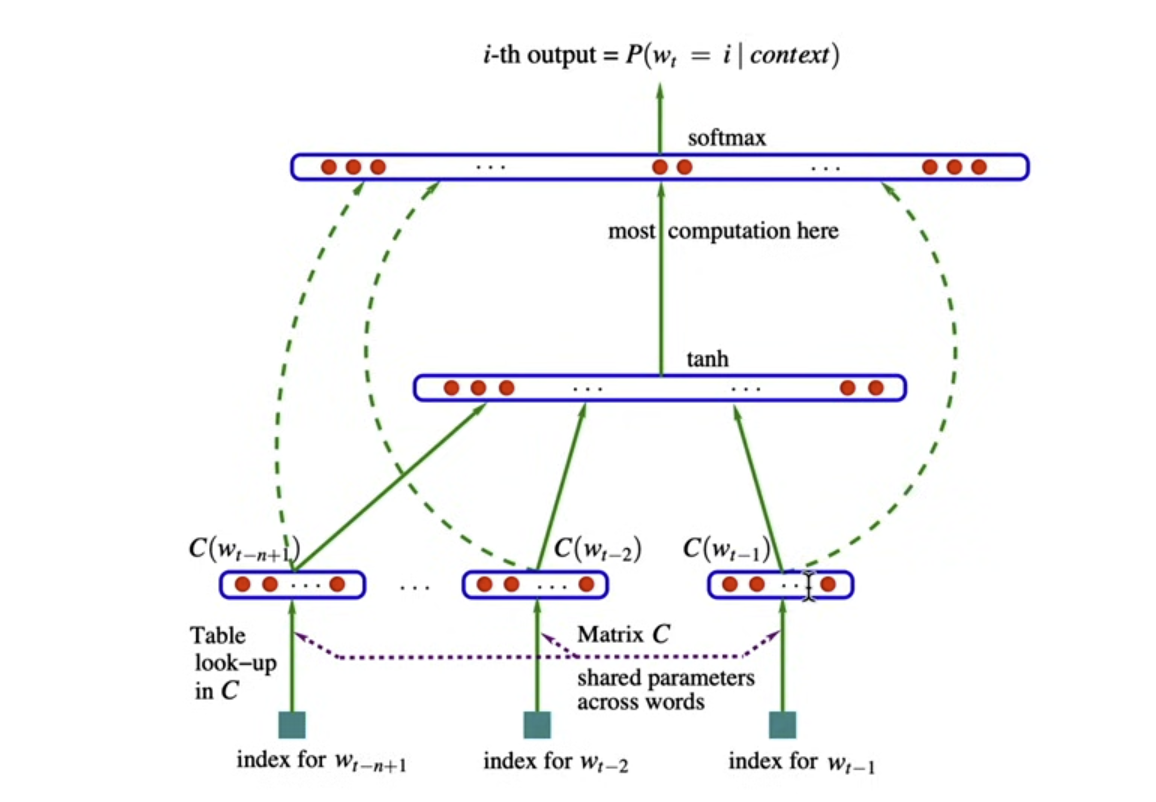

                                                      Bengio et. al (2003)

In [85]:
# build character vocabulary
chars = sorted(list(set(''.join(words))))

# create character to integer mapping
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0

# create integer to character mapping
itoc = {i:c for c,i in ctoi.items()}

itoc

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
# training split (80%)  validation split (10%)  test split (10%)
#    train params         train hyperparam       min loss test

In [130]:
# building the dataset
# ----------------------------------------------------------------------------------------------------------
# context length
block_size = 3

# initialize empty input - label sets
X,Y=[],[]

# populate X and Y training sets
for w in words:

  context = [0]*block_size # initial context array = [000] (maps -> [...]) for each new name
  for ch in w + '.':
    ix = ctoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:]+[ix] # shift left + append next char

X = torch.tensor(X)
Y = torch.tensor(Y)

In [131]:
# X has n entries with a context window of 3 (n rows and 3 entries per row)

# to embedd X onto a 2D vector space, C (lookup table) is created, containing a (unique, random) 2D (feature)..
# ...vector assigned to every one of the 27 possible characters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), requires_grad=True, generator=g) # 2D space

emb = C[X]
# creates a (n x 3 x 2) tensor:
# -> every ith row contains 3 2D tensors (or vectors)
#    -> every ith row in the (3 x 2) tensor is the corresponding 2D feature vector in C at the index X[i]
# i.e., for X[3] (which is [5,13,13]), lets say C[5] = [-0.1345, -1.5183] and C[13] = [0.1375,  0.3588] ...
# ...so C[X[3]] = C[torch.tensor([5,13,13])] = emb[3] [[-0.1345, -1.5183],
#                                                     [0.1375,  0.3588],
#                                                     [0.1375,  0.3588]],

In [132]:
print(f'X[7]: {X[7]}')
print("\n")
print(f'C[X[7]]: {C[X[7]]}')
print("\n")
print(f'emb[7]: {emb[7]}')
print("\n")
print(f'C[[0,15,12]]: {C[[0,15,12]]}')

X[7]: tensor([0, 0, 0])


C[X[7]]: tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373]], grad_fn=<IndexBackward0>)


emb[7]: tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373]], grad_fn=<SelectBackward0>)


C[[0,15,12]]: tensor([[ 1.5674, -0.2373],
        [-1.0725,  0.7276],
        [-0.0707,  2.4968]], grad_fn=<IndexBackward0>)


In [133]:
g = torch.Generator().manual_seed(2147483647)

# 100 neurons in layer 1
W1 = torch.randn((6, 100), requires_grad=True, generator=g)
b1 = torch.randn(100, requires_grad=True, generator=g)

# 27 neurons in layer 2 -> need to output a 27 dim probability vector
W2 = torch.randn((100,27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [149]:
for _ in range(10):

  # constructing minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  #forward pass
  emb = C[X[ix]]

  # Σ X.W + b
  l1 = emb.view(-1,6) @ W1 + b1

  # activation layer
  h = torch.tanh(l1)

  # Σ X.W + b
  logits = h @ W2 + b2
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)

  # loss
  loss = F.cross_entropy(logits, Y[ix])
  print(loss)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward(retain_graph=True)

  # update
  for p in parameters:
    p.data += -0.1 * p.grad


tensor(2.6957, grad_fn=<NllLossBackward0>)
tensor(2.6105, grad_fn=<NllLossBackward0>)
tensor(2.8468, grad_fn=<NllLossBackward0>)
tensor(2.7968, grad_fn=<NllLossBackward0>)
tensor(2.7202, grad_fn=<NllLossBackward0>)
tensor(2.9020, grad_fn=<NllLossBackward0>)
tensor(2.6329, grad_fn=<NllLossBackward0>)
tensor(3.1637, grad_fn=<NllLossBackward0>)
tensor(2.8236, grad_fn=<NllLossBackward0>)
tensor(2.5743, grad_fn=<NllLossBackward0>)


In [159]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+30)
for _ in range(10):
  out=[]
  context=[0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

oai.
hona.
rath.
mhrlh.
asryl.
larao.
rai.
k.
mpai.
gaadyear.


In [ ]:
# much better than bigram for sure